
# 📊 Agentic Python Fixer — Model Performance Dashboard

This notebook loads:
- Per-task **report files** from `reports/*.json`
- The **benchmark log** at `benchmark/benchmark_results.json`

…and generates a few charts to compare **models**, **run types**, and **trends over time**.

In [1]:
import json
from pathlib import Path
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

REPORTS_DIR = Path("../reports")
BENCHMARK_PATH = Path("../benchmark/benchmark_results.json")

print("Reports dir:", REPORTS_DIR.resolve())
print("Benchmark file:", BENCHMARK_PATH.resolve())


Reports dir: C:\Users\LucaS\personal_projects\agentic-python-fixer\reports
Benchmark file: C:\Users\LucaS\personal_projects\agentic-python-fixer\benchmark\benchmark_results.json


In [2]:
def safe_load_json(path: Path):
    try:
        with open(path, "r", encoding="utf-8") as f:
            return json.load(f)
    except Exception as e:
        print(f"Could not load {path}: {e}")
        return None

def load_all_reports(reports_dir: Path):
    out = {}
    for p in reports_dir.glob("*.json"):
        data = safe_load_json(p)
        if isinstance(data, list):
            out[p.as_posix()] = data
    return out

def load_benchmarks(path: Path):
    data = safe_load_json(path)
    if isinstance(data, list):
        return data
    return [data] if data else []


In [3]:
reports = load_all_reports(REPORTS_DIR)
bench = load_benchmarks(BENCHMARK_PATH)

print(f"Loaded {len(reports)} report file(s).")
print(f"Loaded {len(bench)} benchmark run(s).")

def norm_bench_row(row):
    cfg = row.get("config", {})
    summ = row.get("summary", {})
    ts = row.get("timestamp")
    try:
        ts_parsed = datetime.fromisoformat(ts) if ts else None
    except Exception as e:
        print(f"Parsing timestamp failed for '{ts}': {e}")
        ts_parsed = None

    return {
        "timestamp": ts_parsed,
        "timestamp_raw": ts,
        "run_type": cfg.get("run_type"),
        "subset": cfg.get("subset"),
        "max_iters": cfg.get("max_iters"),
        "timeout_secs": cfg.get("timeout_secs"),
        "model_name": cfg.get("model_name"),
        "report_path": "../" + (cfg.get("report") or "").replace("\\\\", "/").replace("\\", "/"),
        "pass_at_1": summ.get("pass_at_1", 0),
        "nb_passed": summ.get("nb_passed", 0),
        "nb_total": summ.get("nb_total"),
    }

bench_df = pd.DataFrame([norm_bench_row(r) for r in bench])
if not bench_df.empty:
    bench_df.sort_values("timestamp", inplace=True)
bench_df


Loaded 4 report file(s).
Loaded 4 benchmark run(s).


,timestamp,timestamp_raw,run_type,subset,max_iters,timeout_secs,model_name,report_path,pass_at_1,nb_passed,nb_total
0,2025-10-20 08:33:24.435450,2025-10-20T08:33:24.435450,hf_api,stratified_0.35,5,10,Qwen/Qwen3-1.7B,../reports/qwen3_1-7b_huggingface_stratified_0...,0.500000,31,62
1,2025-10-20 19:14:01.680508,2025-10-20T19:14:01.680508,hf_api,stratified_0.5,5,10,Qwen/Qwen3-1.7B,../reports/qwen3_1-7b_huggingface_stratified_0...,0.400000,34,85
2,2025-10-21 02:22:05.608424,2025-10-21T02:22:05.608424,openai,stratified_0.35,5,10,gpt-4o mini,../reports/openai_gpt-4o-mini_stratified_0-35....,0.500000,31,62
3,2025-10-21 02:38:09.805883,2025-10-21T02:38:09.805883,openai,stratified_0.5,5,10,gpt-4o mini,../reports/openai_gpt-4o-mini_stratified_0-5.json,0.447059,38,85


In [4]:
def summarize_report(report_tasks):
    if not report_tasks:
        return {
            "nb_tasks": 0,
            "nb_pass": 0,
            "nb_fail": 0,
            "pass_at_1": np.nan,
            "avg_iters_all": np.nan,
            "avg_iters_pass": np.nan,
        }
    df = pd.DataFrame(report_tasks)
    nb_tasks = len(df)
    nb_pass = int((df["status"] == "pass").sum())
    nb_fail = nb_tasks - nb_pass
    pass_rate = nb_pass / nb_tasks if nb_tasks else np.nan
    avg_iters_all = df["nb_trajectory_elems"].mean() if "nb_trajectory_elems" in df else np.nan
    avg_iters_pass = df.loc[df["status"] == "pass", "nb_trajectory_elems"].mean() if "nb_trajectory_elems" in df else np.nan
    return {
        "nb_tasks": nb_tasks,
        "nb_pass": nb_pass,
        "nb_fail": nb_fail,
        "pass_at_1": pass_rate,
        "avg_iters_all": avg_iters_all,
        "avg_iters_pass": avg_iters_pass,
    }

report_rows = []
for path, tasks in reports.items():
    s = summarize_report(tasks)
    s["report_path"] = path
    report_rows.append(s)

report_df = pd.DataFrame(report_rows)
report_df.head()


,nb_tasks,nb_pass,nb_fail,pass_at_1,avg_iters_all,avg_iters_pass,report_path
0,62,31,31,0.500000,10.661290,5.322581,../reports/openai_gpt-4o-mini_stratified_0-35....
1,85,38,47,0.447059,10.894118,4.631579,../reports/openai_gpt-4o-mini_stratified_0-5.json
2,62,31,31,0.500000,10.612903,5.645161,../reports/qwen3_1-7b_huggingface_stratified_0...
3,85,34,51,0.400000,11.447059,5.588235,../reports/qwen3_1-7b_huggingface_stratified_0...


In [5]:
if not report_df.empty and not bench_df.empty:
    merged_df = report_df.merge(bench_df, on="report_path", how="left", suffixes=("_report", "_bench"))
else:
    merged_df = report_df.copy()

merged_df.sort_values(by=["model_name", "timestamp"], inplace=True, na_position="last")
merged_df

,nb_tasks,nb_pass,nb_fail,pass_at_1_report,avg_iters_all,avg_iters_pass,report_path,timestamp,timestamp_raw,run_type,subset,max_iters,timeout_secs,model_name,pass_at_1_bench,nb_passed,nb_total
2,62,31,31,0.500000,10.612903,5.645161,../reports/qwen3_1-7b_huggingface_stratified_0...,2025-10-20 08:33:24.435450,2025-10-20T08:33:24.435450,hf_api,stratified_0.35,5,10,Qwen/Qwen3-1.7B,0.500000,31,62
3,85,34,51,0.400000,11.447059,5.588235,../reports/qwen3_1-7b_huggingface_stratified_0...,2025-10-20 19:14:01.680508,2025-10-20T19:14:01.680508,hf_api,stratified_0.5,5,10,Qwen/Qwen3-1.7B,0.400000,34,85
0,62,31,31,0.500000,10.661290,5.322581,../reports/openai_gpt-4o-mini_stratified_0-35....,2025-10-21 02:22:05.608424,2025-10-21T02:22:05.608424,openai,stratified_0.35,5,10,gpt-4o mini,0.500000,31,62
1,85,38,47,0.447059,10.894118,4.631579,../reports/openai_gpt-4o-mini_stratified_0-5.json,2025-10-21 02:38:09.805883,2025-10-21T02:38:09.805883,openai,stratified_0.5,5,10,gpt-4o mini,0.447059,38,85


In [6]:
def latest_per_model(bdf: pd.DataFrame) -> pd.DataFrame:
    if bdf.empty:
        return bdf

    if not {"model_name", "subset", "timestamp"}.issubset(bdf.columns):
        return bdf
    # index of the latest timestamp per (model_name, subset) to get latest run
    idx = bdf.groupby(["model_name", "subset"])["timestamp"].idxmax()
    idx = idx.dropna().astype(int)
    latest = bdf.loc[idx].sort_values(by=["model_name", "subset", "pass_at_1"], ascending=[True, True, False])
    return latest

latest_df = latest_per_model(bench_df)
latest_df

,timestamp,timestamp_raw,run_type,subset,max_iters,timeout_secs,model_name,report_path,pass_at_1,nb_passed,nb_total
0,2025-10-20 08:33:24.435450,2025-10-20T08:33:24.435450,hf_api,stratified_0.35,5,10,Qwen/Qwen3-1.7B,../reports/qwen3_1-7b_huggingface_stratified_0...,0.500000,31,62
1,2025-10-20 19:14:01.680508,2025-10-20T19:14:01.680508,hf_api,stratified_0.5,5,10,Qwen/Qwen3-1.7B,../reports/qwen3_1-7b_huggingface_stratified_0...,0.400000,34,85
2,2025-10-21 02:22:05.608424,2025-10-21T02:22:05.608424,openai,stratified_0.35,5,10,gpt-4o mini,../reports/openai_gpt-4o-mini_stratified_0-35....,0.500000,31,62
3,2025-10-21 02:38:09.805883,2025-10-21T02:38:09.805883,openai,stratified_0.5,5,10,gpt-4o mini,../reports/openai_gpt-4o-mini_stratified_0-5.json,0.447059,38,85


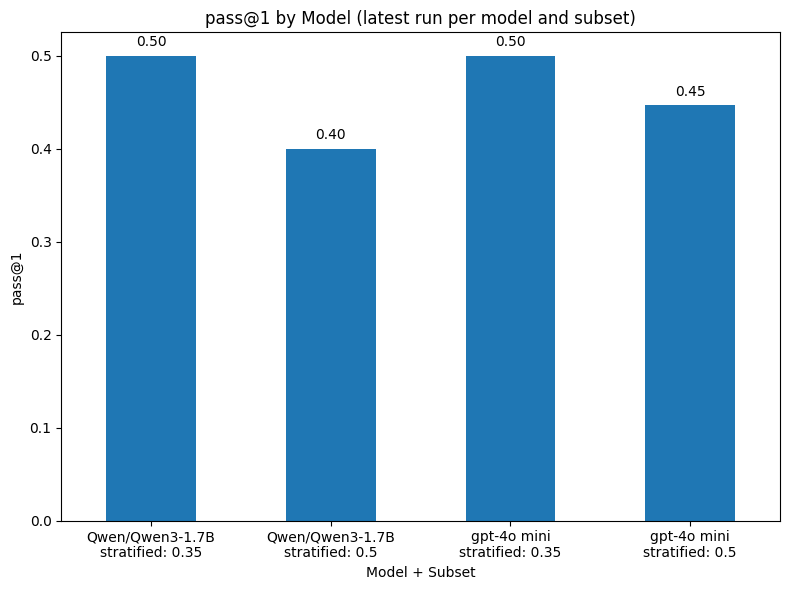

In [7]:
# get labels from model name and subset (handle missing subset)
labels = latest_df.apply(
    lambda r: f"{r['model_name']}\n{(': '.join(r['subset'].split('_'))) if '_' in r['subset'] else (r['subset'] if pd.notna(r['subset']) else 'unknown')}",
    axis=1
)

ax = latest_df.plot(kind="bar", y="pass_at_1", legend=False, figsize=(8,6))
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=0)
ax.set_title("pass@1 by Model (latest run per model and subset)")
ax.set_xlabel("Model + Subset")
ax.set_ylabel("pass@1")

for i, v in enumerate(latest_df["pass_at_1"]):
    ax.text(i, v + 0.01, f"{v:.2f}", ha="center")

plt.tight_layout()
plt.show()

## Plot Analysis
While Qwen3-1.7B has the same performance as gpt-4o mini on the stratified sampling subset for 35% of tasks, it lags behind when 50% of the tasks are considered. This suggests that gpt-4o mini may have a more consistent performance across a broader range of tasks, achieving a more consistent success rate.

This is also shown be the smaller difference in pass@1 between the two subsets for gpt-4o mini (5%) compared to Qwen3-1.7B (10%).

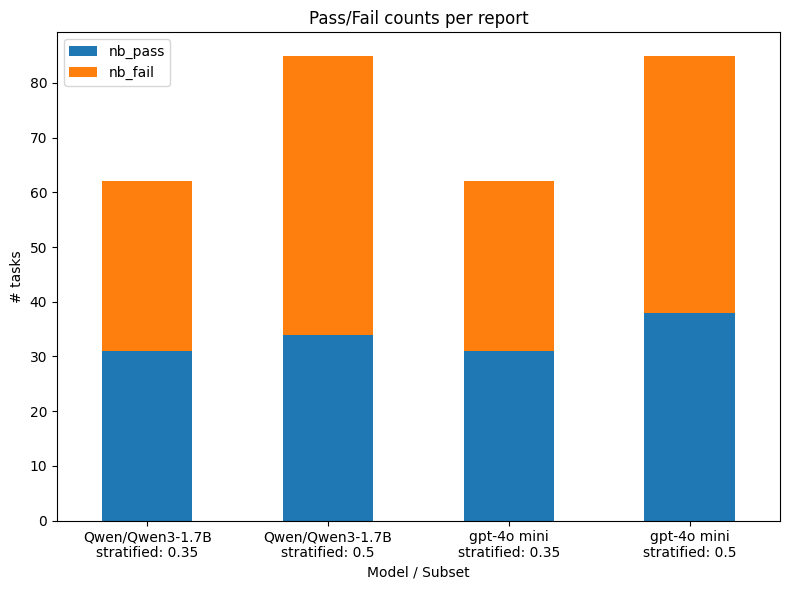

In [8]:
merged_2_df = merged_df.copy()

merged_2_df["label"] = merged_2_df.apply(
    lambda r: f"{(r.get('model_name') if pd.notna(r.get('model_name')) else 'unknown')}\n{Path(str(r.get('report_path') or '')).name}",
    axis=1,
)

ax = merged_2_df.plot(kind="bar", x="label", y=["nb_pass", "nb_fail"], stacked=True, figsize=(8, 6))
ax.set_title("Pass/Fail counts per report")
ax.set_xlabel("Model / Subset")
ax.set_ylabel("# tasks")
ax.set_xticklabels(labels=labels, rotation=0)
plt.tight_layout()
plt.show()

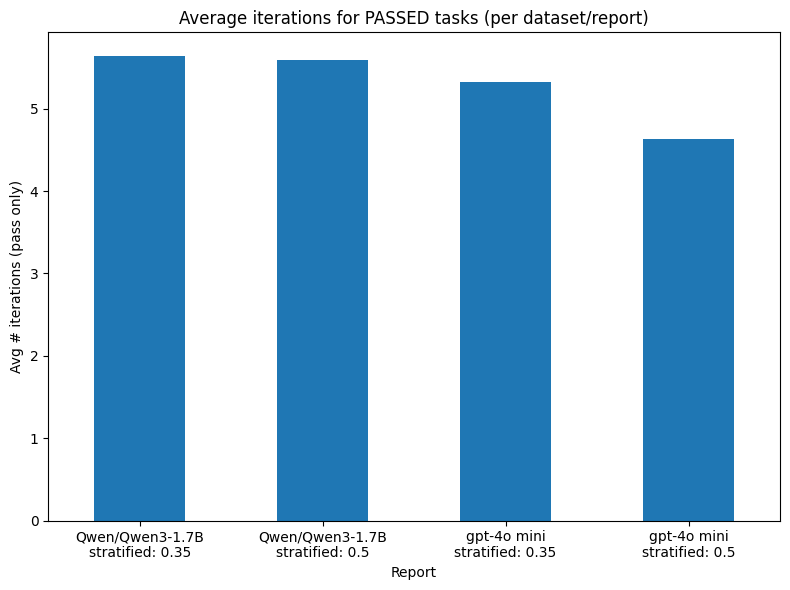

In [9]:
merged_3_df = merged_df.copy()

ax = merged_3_df.plot(kind="bar", x="report_path", y="avg_iters_pass", legend=False, figsize=(8, 6))
ax.set_title("Average iterations for PASSED tasks (per dataset/report)")
ax.set_xlabel("Report")
ax.set_ylabel("Avg # iterations (pass only)")
ax.set_xticklabels(labels=labels, rotation=0)
plt.tight_layout()
plt.show()


## Plot Analysis
This plot likely is explained by the model sizes and capabilities. Larger models like gpt-4o mini can often solve tasks more efficiently, requiring fewer iterations to reach a solution. In contrast, smaller models such as Qwen3-1.7B may need more attempts to arrive at the correct answer, reflecting their limited capacity compared to larger counterparts.